# 3D Nerve Surface Segmentation 

**Add Proper References Here**

**NOTICE:** This notebook assumes you are familiar layered surface detection on tubular objects introduced in the *NerveSegmentation2D* notebook. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imsave 
from skimage.io import imread
from scipy.ndimage.interpolation import map_coordinates

from qimtools import visualization, inspection, io
from slgbuilder import GraphObject,MaxflowBuilder

The objects (nerves) in the volume have two different sizes which need to be handled differently. With small nerves marked in red an large in blue.

In [2]:
in_dir = 'data/'
Vol_path = os.path.join(in_dir, 'nerves3D.tiff')

# Load the data
vol = io.Volume( Vol_path )

# Convert the stack of 2D slices to a 3D volume
vol = vol.concatenate().astype(np.int32)
vol = np.transpose(vol,(1,2,0))

print(vol.shape)

(200, 200, 10)


In [3]:
%matplotlib notebook

<IPython.core.display.Javascript object>


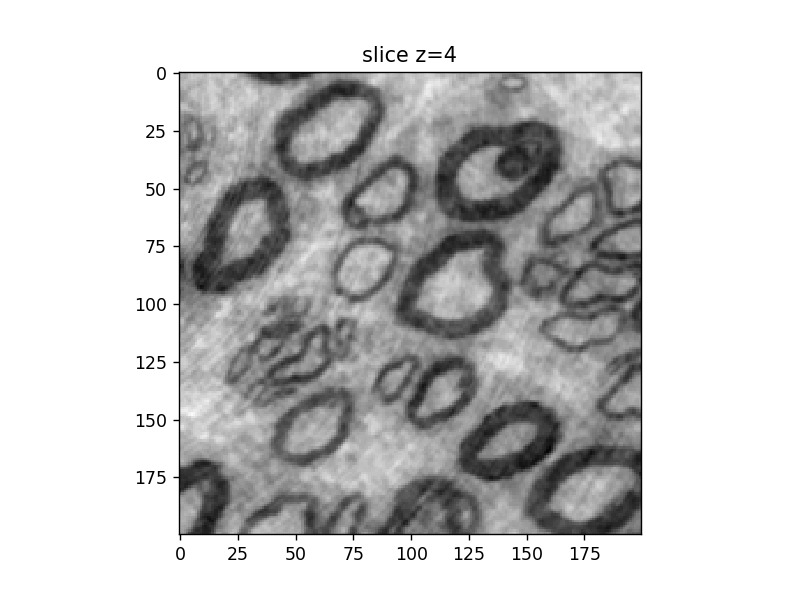

Instructions:
    Controls
    --------
        'up-arrow'    : Next slice in volume
        'down-arrow'  : Previous slice in volume
        'right-arrow' : +10 slices
        'left-arrow'  : -10 slices
        'PgUp'        : +50 slices
        'PgDown'      : -50 slices

        scroll wheel  : previous/next slice
        


In [4]:
visualization.show_vol( vol, axis=2 )

In [5]:
%matplotlib inline

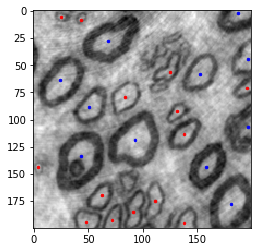

Number of objects: 25


In [7]:
# Get centers
path = in_dir+'nerveCenters.png'
centers = imread(path)[:,:,0]

centers_small = np.transpose(np.where(centers==1))
centers_large = np.transpose(np.where(centers==2))

# Show volume slice with centers.
plt.imshow(vol[...,0], cmap='gray')
plt.scatter(centers_small[..., 1], centers_small[..., 0], color='red', s=6)
plt.scatter(centers_large[..., 1], centers_large[..., 0], color='blue', s=6)
plt.show()

print(f'Number of objects: {len(centers_small)+len(centers_large)}')

In [8]:
def unfold_image(img, center, max_dists=None, r_min=1, r_max=20, angles=30, steps=15):

    # Sampling angles and radii.
    angles = np.linspace(0, 2*np.pi, angles, endpoint=False)
    distances = np.linspace(r_min, r_max, steps, endpoint=True)
    
    if max_dists is not None:
        max_dists.append(np.max(distances))
    
    # Get angles.
    angles_cos = np.cos(angles)
    angles_sin = np.sin(angles)
    
    # Calculate points positions.
    x_pos = center[0] + np.outer(angles_cos, distances)
    y_pos = center[1] + np.outer(angles_sin, distances)
    
    # Create list of sampling points.
    sampling_points = np.array([x_pos, y_pos]).transpose()
    sampling_shape = sampling_points.shape
    sampling_points_flat = sampling_points.reshape((-1, 2))
    
    # Sample from image.
    samples = map_coordinates(img, sampling_points_flat.transpose(), mode='nearest')
    samples = samples.reshape(sampling_shape[:2])
        
    return samples, sampling_points

def draw_segmentations(data, helper,layer=0):
    """Draw all segmentations for objects in the helper on top of the data."""
    
    if data.ndim != 3:
        raise ValueError('Data should be in three dimensions')
    K = (len(helper.objects)//vol.shape[-1])//2
    
    # Create figure.
    plt.figure(figsize=(10, 10))
    plt.imshow(data[...,layer], cmap='gray')
    plt.xlim([0, data[...,layer].shape[1]-1])
    plt.ylim([data[...,layer].shape[0]-1, 0])

    # Draw segmentation lines.
    for i, obj in enumerate(helper.objects):
        if (i >= layer*K and i < (layer+1)*K) or (i >= (vol.shape[-1]+layer)*K and i< (vol.shape[-1]+layer+1)*K):
            # Get segmentation.
            segment = helper.get_labels(obj)
    
            # Create line.
            line = np.count_nonzero(segment, axis=0)
    
            # Get actual points.
            point_indices = tuple(np.asarray([line - 1, np.arange(len(line))]))
            points = obj.sample_points[point_indices]
            # Close line.
            points = np.append(points, points[:1], axis=0)
    
            # Plot points.
            plt.plot(points[..., 1], points[..., 0])

    plt.show()

In [9]:
nerve_samples = []
outer_nerves = []
inner_nerves = []

layers = []

# For each center, create an inner and outer never.
for i in range(vol.shape[-1]):
    for center in centers_small:
            samples, sample_points = unfold_image(vol[...,i], center,r_max=40,angles=40,steps=30)
            nerve_samples.append(samples)
            
            # Create outer and inner nerve objects.
            diff_samples = np.diff(samples, axis=0)
            diff_sample_points = sample_points[:-1]
        
    
            outer_nerves.append(GraphObject(255 - diff_samples, diff_sample_points))
            inner_nerves.append(GraphObject(diff_samples, diff_sample_points))
    for center in centers_large:
            samples, sample_points = unfold_image(vol[...,i], center,r_max=60,angles=40,steps=30)
            nerve_samples.append(samples)
            
            # Create outer and inner nerve objects.
            diff_samples = np.diff(samples, axis=0)
            diff_sample_points = sample_points[:-1]
        
    
            outer_nerves.append(GraphObject(255 - diff_samples, diff_sample_points))
            inner_nerves.append(GraphObject(diff_samples, diff_sample_points))

In [10]:
helper = MaxflowBuilder()
helper.add_objects(outer_nerves + inner_nerves)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)

for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)
    
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 2371864


In [11]:
# Get segmentations.
segmentations = []

# for i in range(vol.shape[0]):
for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    segmentations.append(helper.get_labels(outer_nerve))
    segmentations.append(helper.get_labels(inner_nerve))

segmentation_lines = [np.count_nonzero(s, axis=0) - 0.5 for s in segmentations]

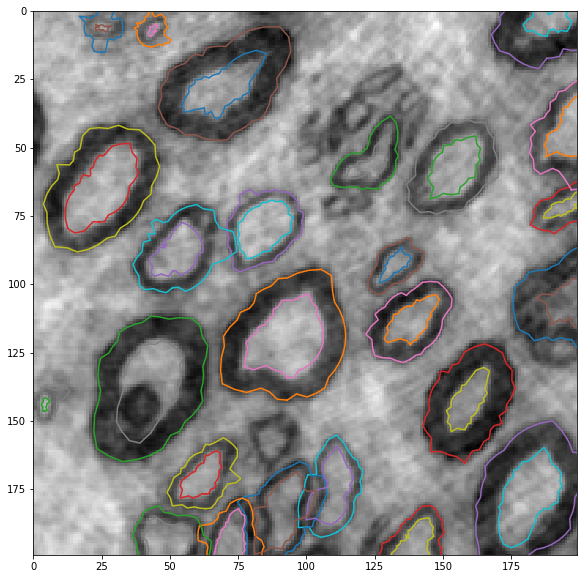

In [12]:
draw_segmentations(vol, helper,layer=3)

In [13]:
from slgbuilder import QPBOBuilder

helper = QPBOBuilder()
helper.add_objects(outer_nerves + inner_nerves)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)

for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)
    
twice_flow = helper.solve()
print('Two times maximum flow/minimum energy:', twice_flow)

if 2*flow == twice_flow:
    print('QPBO flow is exactly twice the Maxflow flow.')
else:
    print('Something is wrong...')

Two times maximum flow/minimum energy: 4743728
QPBO flow is exactly twice the Maxflow flow.


In [14]:
# Add exclusion constraints between all pairs of outer nerves.
interval = len(outer_nerves)//vol.shape[-1]
for i in range(vol.shape[-1]):
        for j in range(len(outer_nerves)//vol.shape[-1]):
            for k in range(j + 1, len(outer_nerves)//vol.shape[-1]):
                helper.add_layered_exclusion(outer_nerves[interval*i+j], 
                                             outer_nerves[interval*i+k], margin=3)

In [15]:
twice_flow = helper.solve()
print('Two times maximum flow/minimum energy:', twice_flow)

Two times maximum flow/minimum energy: 4750444


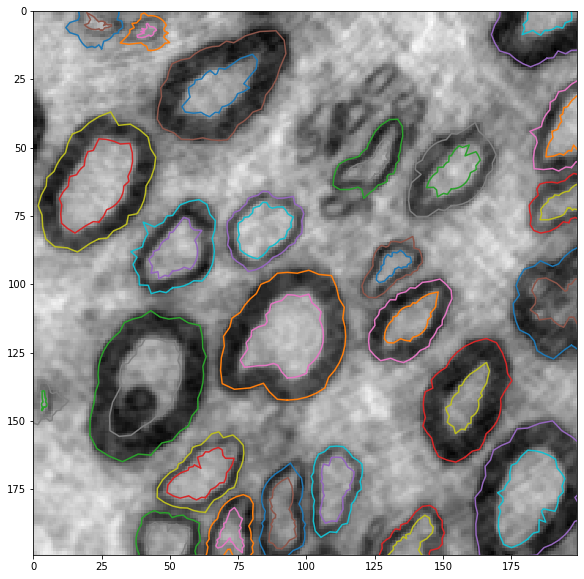

In [16]:
draw_segmentations(vol, helper,layer=9)